# Setup

## Imports

In [1]:
import csv
import os.path
import librosa
import librosa.display
import itertools

from IPython import display
from glob import glob
from time import time
from tqdm import tqdm_notebook as tqdm

vai Modules

In [2]:
from vai_.utils.utils import randpick, summarize_tensor
from vai_.io import pickle_dump, pickle_load
from vai_.torch.stats import ModelStats

Keras Modules

In [3]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


Torch Modules

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable

In [5]:
from utils.wavenet_vocoder.audio import melspectrogram
from utils.wavenet_vocoder.audio import _denormalize

## Define Useful Features

In [6]:
DIR_DATA = DIR_DATA['LJSpeech']

In [7]:
cuda = lambda x: x.cuda() if use_gpu and torch.cuda.is_available() else x

In [8]:
hear = lambda x: display.Audio(x, rate=sample_rate)

In [9]:
read_transcript = lambda x: ''.join(idx_char[i] for i in x)

In [10]:
def show_sound(filename):
    x = librosa.load(filename, sr=sample_rate)[0]
    plot(x)
    title = char_seq[os.path.split(filename)[-1][:-4]]
    for i in range(60, len(title), 60):
        j = i + title[i:].find(' ')
        title = title[:j] + '\n' + title[j:]
    plt.title(title)
    plt.show()
    
    return x

In [11]:
get_spectrogram = lambda x: melspectrogram(x).astype(np.float32)

In [12]:
def plot_spectrogram(spectrogram):
    librosa.display.specshow(_denormalize(spectrogram), sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.title('Mel spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.set_cmap('viridis')
    plt.show()

In [13]:
def load_model():
    global model, history
    if not os.path.exists(os.path.join(DIR_CHECKPOINTS, 'model.pt')): return
    model.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'model.pt')))
    
    history = pickle_load(os.path.join(DIR_CHECKPOINTS, 'history.p'))

In [14]:
get_spectrogram = lambda y: librosa.power_to_db(librosa.feature.melspectrogram(y, n_fft=num_fft,
                                                           hop_length=hop_length,
                                                           n_mels=num_mels,fmin=min_freq,
                                                           fmax=max_freq), ref=np.max).astype(np.float32) / 40 + 1

In [15]:
def save_model():
    torch.save(model.state_dict(), os.path.join(DIR_CHECKPOINTS, 'model.pt'))
    pickle_dump(os.path.join(DIR_CHECKPOINTS, 'history.p'), history)

## HyperParameters

In [16]:
train_files = -1
val_split = 0.01

In [17]:
# Optimizer
lr_initial = 1e-3
lr_final = 1e-5
lr_decay_iterations = 50000
lr_decay_rate = 1 - 1e-4
weight_decay = 1e-6

In [18]:
sample_rate = 22050
num_mels = 80
num_fft = int(50 * 1e-3 * sample_rate)
hop_length = int(12.5 * 1e-3 * sample_rate)
min_freq = 125
max_freq = 7.6 * 1e3

In [19]:
# Encoder
embedding_dim = 512
encoder_conv_filters = 512
encoder_conv_len = 5
encoder_num_conv = 3
encoder_lstm_hidden = 256

In [20]:
# Attention
attn_hidden = 128
attn_conv_filters = 32
attn_conv_len = 31
attn_window_len = 5

In [21]:
# Decoder
decoder_num_pre = 2
decoder_pre_hidden = 256
decoder_num_lstm = 2
decoder_lstm_hidden = 1024
decoder_num_conv = 5
decoder_conv_filters = 512
decoder_conv_len = 5

In [22]:
p_dropout = 0.5
p_zoneout = 0.1

In [23]:
use_bias = True
batch_size = 1
use_gpu = True

## Load Data

### Load Filenames and Transcripts

In [24]:
filenames = sorted(glob(os.path.join(DIR_DATA, 'wavs', '*.wav')))

In [25]:
with open(os.path.join(DIR_DATA, 'metadata.csv')) as f:
    csv_reader = csv.reader(f, delimiter='|')
    char_seq = {}
    for line in csv_reader:
        char_seq[line[0]] = line[-1]

In [26]:
no_transcripts = []
transcripts = []
for i, filename in enumerate(filenames):
    k = os.path.split(filename)[-1][:-4]
    if k in char_seq.keys():
        transcripts.append(char_seq[k])
    else:
        no_transcripts.append(i)

In [27]:
for i in no_transcripts:
    filenames.pop(i)

In [28]:
sample_audio = show_sound(randpick(filenames))
hear(sample_audio)

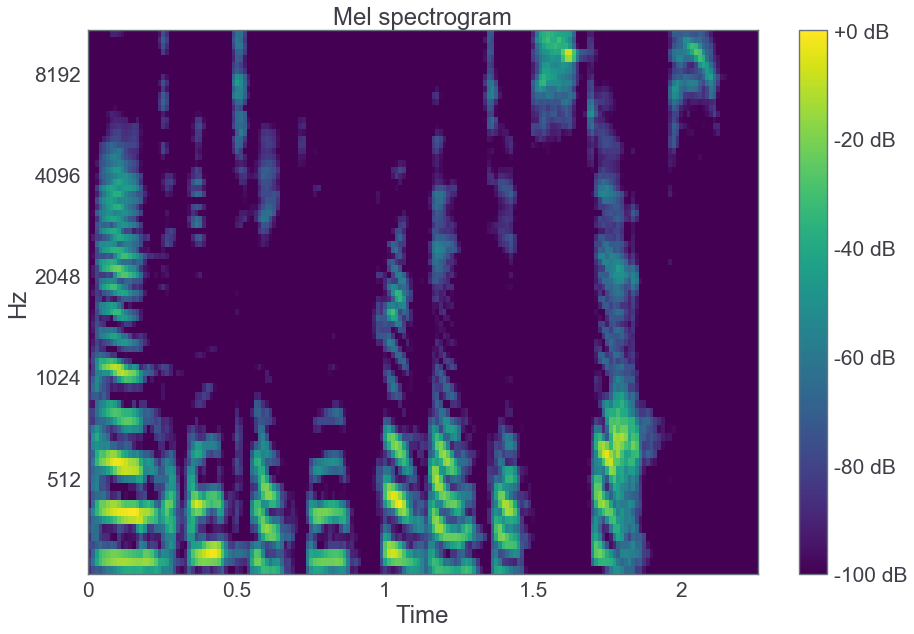

In [29]:
sample_spectrogram = get_spectrogram(sample_audio)
plot_spectrogram(sample_spectrogram)

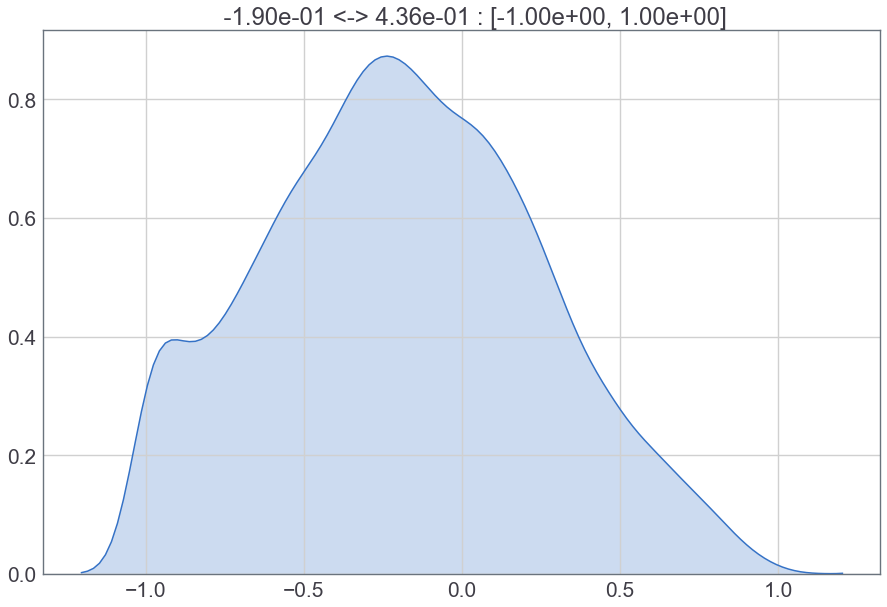

In [30]:
summarize_tensor(sample_spectrogram, kde=True)

### Tokenize

In [31]:
tokenizer = Tokenizer(filters='', char_level=True)

In [32]:
tokenizer.fit_on_texts(transcripts)

In [33]:
transcripts = [np.array(tokenizer.texts_to_sequences([t])[0]) for t in transcripts]

In [34]:
char_idx = tokenizer.word_index
idx_char = {v: k for k, v in char_idx.items()}
vocab_size = len(char_idx)

In [35]:
''.join(idx_char[i] for i in transcripts[0])

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

Reduce to training and validation datasets

In [36]:
'''if os.path.exists(os.path.join(DIR_CHECKPOINTS, 'file_len.npy')):
    file_len = np.load(os.path.join(DIR_CHECKPOINTS, 'file_len.npy'))
else:
    file_len = np.array([len(librosa.load(file)[0]) for file in tqdm(filenames)])
    file_len = np.argsort(file_len)
    np.save(os.path.join(DIR_CHECKPOINTS, 'file_len.npy'), file_len)

filenames = np.array(filenames)[file_len].tolist()
transcripts = np.array(transcripts)[file_len].tolist()
'''

"if os.path.exists(os.path.join(DIR_CHECKPOINTS, 'file_len.npy')):\n    file_len = np.load(os.path.join(DIR_CHECKPOINTS, 'file_len.npy'))\nelse:\n    file_len = np.array([len(librosa.load(file)[0]) for file in tqdm(filenames)])\n    file_len = np.argsort(file_len)\n    np.save(os.path.join(DIR_CHECKPOINTS, 'file_len.npy'), file_len)\n\nfilenames = np.array(filenames)[file_len].tolist()\ntranscripts = np.array(transcripts)[file_len].tolist()\n"

In [37]:
if train_files < 0: train_files = len(filenames)
filenames_train = filenames[:train_files]
transcripts_train = transcripts[:train_files]

In [38]:
val_idx = max(int((1 - val_split) * len(filenames_train)), 1)
filenames_val = filenames_train[val_idx:]
transcripts_val = transcripts_train[val_idx:]

filenames_train = filenames_train[:val_idx]
transcripts_train = transcripts_train[:val_idx]

del val_idx

### Generator

In [39]:
batches_per_epoch = len(filenames_train) // batch_size

In [40]:
def data_generator(teacher_force=True, train=True):
    while True:
        if train:
            file_idx = np.random.randint(len(filenames_train))
            transcript = torch.from_numpy(np.expand_dims(transcripts_train[file_idx], 0))
            y = librosa.load(filenames_train[file_idx], sr=sample_rate)[0]
        else:
            file_idx = np.random.randint(len(filenames_val))
            transcript = torch.from_numpy(np.expand_dims(transcripts_val[file_idx], 0))
            y = librosa.load(filenames_val[file_idx], sr=sample_rate)[0]
            
        spectrogram = torch.from_numpy(get_spectrogram(y))
        stop_probs = torch.linspace(0, 1, spectrogram.size(1))
        if teacher_force:
            yield Variable(cuda(transcript)), Variable(cuda(spectrogram)), Variable(cuda(stop_probs))
        else:
            yield Variable(cuda(transcript), volatile=True), Variable(cuda(spectrogram), volatile=True), Variable(cuda(stop_probs), volatile=True)

# Create Model

## TODOs

<font color=red>
Fix BiLSTM
    
Add Regularization

Make initial states of Encoder and Decoder as params

Add Relu to Attention alpha-conv

## Regularized Layers

In [41]:
printer = lambda verbosity: print if verbosity > 0 else lambda *args: None

In [42]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, bias=True):
        super().__init__()
        conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride,
                              padding=padding, dilation=dilation,
                              groups=groups, bias=bias)
        dropout = nn.Dropout(p=p_dropout, inplace=True)
        self.net = nn.Sequential(conv, dropout)
        
    def forward(self, x):
        return self.net(x)

In [43]:
class PreNetLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        fc = nn.Linear(in_features, out_features, bias=bias)
        dropout = nn.Dropout(p=p_dropout, inplace=True)
        self.net = nn.Sequential(fc, dropout)
        
    def forward(self, x):
        return self.net(x)

In [44]:
def zoneout(x, x_prev, p, train):
    if not train: return x
    
    retain_mask = torch.rand(x.size()).le(p)
    
    return retain_mask.float() * x_prev + (~retain_mask).float() * x

In [45]:
class LSTM(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.zoneout_prob = kwargs.pop('zoneout', None)
        self.lstm = nn.LSTM(*args, **kwargs)
        
        self.lstm.num_directions = 2 if self.lstm.bidirectional else 1
        
    def forward(self, x, hx=None, verbosity=0):
        if self.zoneout_prob is None: return self.lstm(x, hx)
        
        _print = printer(verbosity)
        _print('before transpose, x', x.size())
        iterator =  torch.transpose(x, 0, 1) if self.lstm.batch_first else x
        _print('after transpose, iterator', iterator.size())
        seq_len, batches = iterator.shape[:2]
        _print('unpack, seq_len, batches', seq_len, batches)
        outputs = Variable(cuda(torch.zeros(seq_len, batches, self.lstm.hidden_size * self.lstm.num_directions)))
        outputs = torch.transpose(outputs, 0, 1) if self.lstm.batch_first else outputs
        _print('outputs', outputs.size())
        
        if hx is None:
            h_prev = Variable(cuda(torch.zeros(self.lstm.num_layers * self.lstm.num_directions, batches, self.lstm.hidden_size)))
            c_prev = Variable(cuda(torch.zeros(self.lstm.num_layers * self.lstm.num_directions, batches, self.lstm.hidden_size)))
        else:
            h_prev, c_prev = hx
        _print('h_prev, c_prev', h_prev.size(), c_prev.size())
        
        _print = printer(verbosity - 1)
        for i, x_i in enumerate(iterator):
            _print('\nAt iteration', i)
            expand_dim = 1 if self.lstm.batch_first else 0
            x_i = x_i.unsqueeze(expand_dim)
            _print('before lstm, x_i', x_i.size())
            output, (h, c) = self.lstm(x_i, (h_prev, c_prev))
            _print('after lstm, output, h_prev, c_prev', output.size(), h_prev.size(), c_prev.size())
            if self.lstm.batch_first:
                outputs[:, i] = output.squeeze(expand_dim)
            else:
                outputs[i] = output.squeeze(expand_dim)
            
            # Magic
            h_prev = zoneout(h, h_prev, self.zoneout_prob, self.training)       
            c_prev = zoneout(c, c_prev, self.zoneout_prob, self.training)
            
            _print('After zoneout, h_prev, c_prev', h_prev.size(), c_prev.size())
            
        return outputs, (h_prev, c_prev)

## Encoder

In [46]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.conv = nn.ModuleList([Conv(embedding_dim, encoder_conv_filters,
                                             encoder_conv_len, padding=2, bias=True)])
        self.conv.extend([Conv(encoder_conv_filters, encoder_conv_filters,
                                    encoder_conv_len, padding=2, bias=True)
                          for _ in range(encoder_num_conv - 1)])
        
        self.bn = nn.ModuleList([nn.BatchNorm1d(encoder_conv_filters)
                                 for _ in range(encoder_num_conv)])
        
        self.lstm = LSTM(input_size=encoder_conv_filters, hidden_size=encoder_lstm_hidden,
                            num_layers=1, batch_first=True, bidirectional=True)
    
    def forward(self, x, verbose=0):
        _print = printer(verbose)
        
        _print('in', x.size())
        x = torch.transpose(self.embedding(x), 1, 2)
        _print('embed', x.size())
        
        _print = printer(verbose - 1)
        _print('\nEntering conv net')
        for i, (bn, conv) in enumerate(zip(self.bn, self.conv)):
            x = F.relu(bn(conv(x)), inplace=True)
            _print('After iteration', i, x.size())
        _print = printer(verbose)
        
        x = torch.transpose(x, 1, 2)

        x = self.lstm(x)[0]
        _print('\nafter lstm', x.size())
        return x

## Attention

In [47]:
class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc_s = nn.Linear(decoder_lstm_hidden, attn_hidden, bias=True)
        self.fc_h = nn.Linear(encoder_lstm_hidden * 2, attn_hidden, bias=True)
        self.conv = Conv(1, attn_conv_filters, attn_conv_len,
                              padding=(attn_conv_len - 1) // 2, bias=True)
        self.fc_conv = nn.Linear(attn_conv_filters, attn_hidden, bias=True)
        self.fc = nn.Linear(128, 1, bias=True)
    
    def forward(self, s, verbose=0):
        _print = printer(verbose)
            
        _print('s', s.size())
        s = self.fc_s(s)
        _print('After fc_s, s', s.size())
        
        _print('Before conv, self.last_attn', self.last_attn.size())
        convs = self.conv(self.last_attn.view(1, 1, -1))
        _print('After conv(self.last_attn), convs', convs.size())
        convs = torch.transpose(convs[0], 0, 1)
        _print('After transpose, convs', convs.size())
        convs = self.fc_conv(convs)
        _print('After self.fc_conv, convs', convs.size())
        
        scores = F.tanh(s + self.hs + convs)
        scores = self.fc(scores)

        self.last_attn = torch.transpose(F.softmax(scores, dim=0), 0, 1)
        _print('After softmax, self.last_attn', self.last_attn.size())
        
        
        _print('Before mul, self.last_attn', self.last_attn.size(),
              ', self.encoder_hidden', self.encoder_hidden.size())
        context = torch.mm(self.last_attn, self.encoder_hidden)
        _print('After mul, context', context.size())

        return context
    
    def reset(self, encoder_hidden, verbose=0):
        _print = printer(verbose)
        _print('\nResetting attention\n')
        
        self.encoder_hidden = encoder_hidden[0]
        self.last_attn = Variable(cuda(torch.zeros(1, encoder_hidden.size(1))))
        #self.last_attn = Variable(cuda(torch.arange(encoder_hidden.size(1), 0, -1)))
        #self.last_attn = torch.unsqueeze(F.softmax(self.last_attn, dim=-1), 0)
        self._initialize(verbose - 1)
        _print('Reseting, self.encoder_hidden', self.encoder_hidden.size(),
             'self.last_attn', self.last_attn.size(), '\n\n')
        
        print = _print
        
    def _initialize(self, verbose=0):
        _print = printer(verbose)
        _print('\nInitializing h for the first time\n')
        _print('Before fc_h, self.encoder_hidden', self.encoder_hidden.size())
        self.hs = self.fc_h(self.encoder_hidden)
        _print('After fc_h, self.hs', self.hs.size())
        _print('\n\n')
        
    def _find_median(self):
        x = self.last_attn[0].data
        
        indices_nonzero = torch.nonzero(x)
        if len(indices_nonzero) == 0:
            return 0, attn_window_len + 1
        x = x[indices_nonzero[:, 0]]
        indices = torch.sort(x)[1]
        indices = indices_nonzero[indices]
        idx = (len(x) + 1) // 2
        idx = indices[idx]
        start_idx = idx - (attn_window_len + 1)//2
        if start_idx[0] < 0:
            return 0, attn_window_len + 1
        
        end_idx = idx + (attn_window_len + 1)//2
        return start_idx[0], end_idx[0]

## Decoder

In [48]:
class Decoder(nn.Module):
    def __init__(self, attention):
        super().__init__()     
        self.attention = attention
        
        self.pre_net = nn.ModuleList([PreNetLinear(num_mels, decoder_pre_hidden)])
        self.pre_net.extend([PreNetLinear(decoder_pre_hidden, decoder_pre_hidden)
                            for _ in range(decoder_num_pre - 1)])
        
        self.lstm = LSTM(input_size=decoder_pre_hidden + encoder_lstm_hidden * 2,
                            hidden_size=decoder_lstm_hidden, num_layers=decoder_num_lstm,
                            batch_first=True)
        self.fc = nn.Linear(decoder_lstm_hidden + encoder_lstm_hidden * 2,
                            num_mels)
        self.fc_stop = nn.Linear(decoder_lstm_hidden + encoder_lstm_hidden * 2,
                                 1, bias=True)
        
        self.post_net = nn.ModuleList([nn.Conv1d(num_mels, decoder_conv_filters,
                                                 decoder_conv_len,
                                                 padding=decoder_conv_len // 2, bias=True)])
        self.post_net.extend([Conv(decoder_conv_filters, decoder_conv_filters,
                                                 decoder_conv_len,
                                                 padding=decoder_conv_len // 2, bias=True)
                                      for _ in range(decoder_num_conv - 2)])
        self.final_post_net = Conv(decoder_conv_filters, num_mels,
                                        decoder_conv_len,
                                        padding=decoder_conv_len // 2, bias=True)
        self.bn = nn.ModuleList([nn.BatchNorm1d(decoder_conv_filters)
                                 for _ in range(decoder_num_conv - 1)])
        
    def forward(self, encoder_hidden, spectrogram, max_len, stop_threshold, verbose):
        _print = printer(verbose)
        stop_threshold = -np.log(1 / stop_threshold - 1)
        
        teacher_force = True
        if self.training:
            if spectrogram is None:
                raise ValueError('Feed spectrogram while training.')
        else:
            if spectrogram is None:
                spectrogram = Variable(cuda(torch.zeros(num_mels, max_len)))
                teacher_force = False
        
        last_pred = Variable(cuda(torch.zeros(1, num_mels)))
        prev_hidden = Variable(cuda(torch.zeros(decoder_num_lstm, 1, decoder_lstm_hidden)))
        prev_cell = Variable(cuda(torch.zeros(decoder_num_lstm, 1, decoder_lstm_hidden)))
        
        spectrogram = torch.transpose(spectrogram, 0, 1)
        stop_probs = Variable(cuda(torch.zeros(spectrogram.size(0))))
        predictions = Variable(cuda(torch.zeros(spectrogram.size())))

        _print('Initially, prev_hidden', prev_hidden.size(), 'prev_cell', prev_cell.size())
        self.attention.reset(encoder_hidden, verbose - 4)
        attn_probs = []
        _print = printer(verbose - 1)
        for i, correct_pred in enumerate(spectrogram):
            _print('At iteration', i)
            pre_out = last_pred

            _print = printer(verbose - 2)
            _print('Entering pre_net loop')
            for j, pre_net in enumerate(self.pre_net):
                _print('Before pre_net[', j, '], pre_out', pre_out.size())
                pre_out = F.relu(pre_net(pre_out), inplace=True)
                _print('After pre_net[', j, '], pre_out', pre_out.size())
            _print = printer(verbose - 1)

            attn_context = self.attention(prev_hidden[-1], verbose - 4)
            attn_probs.append(self.attention.last_attn.data.cpu().numpy())
            _print('After attn attn_context', attn_context.size())

            out = torch.unsqueeze(torch.cat([pre_out, attn_context], dim=-1), dim=1)
            _print('After concatenation [pre_out, attn_context], out', out.size())
            lstm_out, (prev_hidden, prev_cell) = self.lstm(out, (prev_hidden, prev_cell))
            _print('After lstm, lstm_out', lstm_out.size(), ', prev_hidden',
                 prev_hidden.size(), ', prev_cell', prev_cell.size())

            out = torch.cat([lstm_out.squeeze(1), attn_context], dim=-1)
            _print('After concatentaion [lstm_out, attn_context]', out.size())
            pre_out = self.fc(out)
            _print('After fc, pre_out', pre_out.size())
            stop_probs[i] = self.fc_stop(out.detach())
            _print('After fc_stop, stop_probs[-1]', stop_probs[-1])
            out = torch.unsqueeze(pre_out, -1)

            last_pred = torch.unsqueeze(correct_pred, dim=0) if teacher_force else pre_out
            predictions[i] = pre_out
            
            if teacher_force:
                continue
            elif stop_probs[i].data.cpu().numpy()[0] > stop_threshold:
                stop_probs = stop_probs[:i + 1]
                predictions = predictions[:i + 1]
                break

        _print = printer(verbose)
        pre_predictions = torch.transpose(predictions, 0, 1)
        _print('\n\nAfter transpose, pre_predictions', pre_predictions.size())

        _print = printer(verbose - 3)
        _print('Entering post_net loop')
        out = torch.unsqueeze(pre_predictions, 0)
        for i, (post_net, bn) in enumerate(zip(self.post_net, self.bn)):
            _print('Before', i, 'iteration of post_net, out', out.size())
            out = F.tanh(bn(post_net(out)))
            _print('After', i, 'iteration of post_net, out', out.size())
        out = self.final_post_net(out)
        _print('After last post_net, out', out.size())
        _print = printer(verbose)

        post_predictions = pre_predictions + torch.squeeze(out, dim=0)
        _print('After adding, post_predictions', post_predictions.size())
        
        return pre_predictions, post_predictions, stop_probs, np.vstack(attn_probs)

## Model

In [49]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(Attention())
        
    def forward(self, transcript, spectrogram=None, **kwargs):
        max_len = kwargs.pop('max_len', 500)
        stop_threshold = kwargs.pop('stop_threshold', 0.9)
        verbose = kwargs.pop('verbose', 0)
        
        _print = printer(verbose)
        _print('Entering encoder\n')
        encoder_hidden = self.encoder(transcript, verbose - 10)
        
        _print('\nEntering decoder\n')
        decoded = self.decoder(encoder_hidden, spectrogram, max_len, stop_threshold,
                               verbose - 20)
        return decoded

In [50]:
model = cuda(Model())
history = {'iterations': 0, 'running_iterations': [], 'time': [], 'pre_loss': [],
           'post_loss': [], 'stop_loss': [], 'val_pre_loss': [], 'val_post_loss': [],
           'val_stop_loss': [], 'lr': [], 'last_lr': lr_initial,
           'running_loss': {'pre': [], 'post': [], 'stop': []}}

In [51]:
optimizer = optim.Adam(model.parameters(), lr=lr_initial, eps=1e-6, weight_decay=weight_decay)

In [52]:
criterion_mse = nn.MSELoss()
criterion_bce = nn.BCEWithLogitsLoss()

# Train

In [53]:
def get_loss(gen, train=True):
    transcript, spectrogram, stop_tokens = next(gen)
    if not train:
        model.eval()
        pre_predictions, post_predictions, stop_probs, _ = model(transcript, stop_threshold=1, max_len=spectrogram.shape[1])
    else:
        model.train()
        pre_predictions, post_predictions, stop_probs, _ = model(transcript, spectrogram)
    
    loss_dict = {}
    pre_loss = criterion_mse(torch.transpose(pre_predictions, 0, 1), torch.transpose(spectrogram, 0, 1))
    post_loss = criterion_mse(torch.transpose(post_predictions, 0, 1), torch.transpose(spectrogram, 0, 1))
    stop_loss = criterion_bce(stop_probs, stop_tokens)
    
    loss = pre_loss + stop_loss + post_loss
    
    loss_dict['pre'] = pre_loss.data.cpu().numpy()[0]
    loss_dict['post'] = post_loss.data.cpu().numpy()[0]
    loss_dict['stop'] = stop_loss.data.cpu().numpy()[0]
    
    return loss, loss_dict

In [54]:
def optimize(iterations=1, stats=None, save_every=1):
    load_model()
    model.train()
    optimizer.param_groups[0]['lr'] = history['last_lr']
    
    start_time = time()
    
    gen = data_generator()
    gen_val = data_generator(teacher_force=False, train=False)
    prog_bar = tqdm(range(history['iterations'], history['iterations'] + iterations))
    
    for iteration, start_idx in enumerate(prog_bar):
        loss, loss_dict = get_loss(gen)

        optimizer.zero_grad()
        loss.backward()
        if stats is not None: stats.read()
        optimizer.step()
        
        for k in loss_dict.keys(): history['running_loss'][k].append(loss_dict[k])

        if len(history['running_loss']['pre']) > batches_per_epoch:
            for k in loss_dict.keys(): history['running_loss'][k].pop(0)

        mean_loss = sum(history['running_loss']['post']) / len(history['running_loss']['post'])

        prog_bar.set_description('loss:{:.4f}'.format(mean_loss))

        history['iterations'] += 1
        if history['iterations'] > lr_decay_iterations:
            optimizer.param_groups[0]['lr'] *= lr_decay_rate
            optimizer.param_groups[0]['lr'] += lr_final * (1 - lr_decay_rate)
            history['last_lr'] = optimizer.param_groups[0]['lr']

        if time() - start_time > save_every * 60 or history['iterations'] % 100 == 0:
            history['running_iterations'].append(history['iterations'])
            history['time'].append(time())
            for k in loss_dict.keys():
                history[k + '_loss'].append(sum(history['running_loss'][k]) / len(history['running_loss'][k]))
            history['lr'].append(optimizer.param_groups[0]['lr'])
            
            if len(filenames_val) > 0:
                val_loss_dict = get_loss(gen_val, train=False)[1]
                model.train()
                for k in val_loss_dict.keys(): history['val_' + k + '_loss'].append(val_loss_dict[k])
            
            save_model()
            start_time = time()

    save_model()
    
    prog_bar.close()

In [55]:
def plot_progress():
    plot(history['pre_loss'], label='pre')
    plot(history['post_loss'], label='post')
    plot(history['val_pre_loss'], '--b', label='pre_val')
    plot(history['val_post_loss'], '--g', label='post_val')
    plt.yscale('log')
    plt.legend()
    plt.show()
    plot(history['stop_loss'], label='stop')
    plot(history['val_stop_loss'], label='stop_val')
    plt.legend()
    plt.show()

# Optimize

In [56]:
stats = ModelStats(model)

In [57]:
optimize(5000, stats=stats)
optimizer.zero_grad()

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

/home/vaisakh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


KeyboardInterrupt: 

In [ ]:
stats.show(cond=lambda x: x < -6, verbose=False)

In [ ]:
plot_progress()

# Sample

In [61]:
%%capture
load_model()
model.eval()

In [66]:
sample_transcript, sample_spectrogram, stop_tokens = next(data_generator(teacher_force=False, train=False))
pre_preds, post_preds, stop_probs, attn_probs = model(sample_transcript, stop_threshold=0.9, max_len=sample_spectrogram.size(1), verbose=500)

Entering encoder

in torch.Size([1, 148])
embed torch.Size([1, 512, 148])

Entering conv net
After iteration 0 torch.Size([1, 512, 148])
After iteration 1 torch.Size([1, 512, 148])
After iteration 2 torch.Size([1, 512, 148])

after lstm torch.Size([1, 148, 512])

Entering decoder

Initially, prev_hidden torch.Size([2, 1, 1024]) prev_cell torch.Size([2, 1, 1024])

Resetting attention


Initializing h for the first time

Before fc_h, self.encoder_hidden torch.Size([148, 512])
After fc_h, self.hs torch.Size([148, 128])



Reseting, self.encoder_hidden torch.Size([148, 512]) self.last_attn torch.Size([1, 148]) 


At iteration 0
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.S

After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop, stop_probs[-1] Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 50
Entering pre_net loop
Before pre_net[ 0 ], pre_

After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop, stop_probs[-1] Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 113
Entering pre_net loop
Before pre_net[ 0 ], pre

Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop

After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop, stop_probs[-1] Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 218
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 

s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop, stop_probs[-1] Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 289
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_

After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop, stop_probs[-1] Variable containing:
 0
[torch.c

After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop, stop_probs[-1] Variable containing:
 0
[torch.c

Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop

After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop, stop_probs[-1] Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 527
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 

At iteration 585
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pr

At iteration 641
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pr

After fc, pre_out torch.Size([1, 80])
After fc_stop, stop_probs[-1] Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 700
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch

After pre_net[ 1 ], pre_out torch.Size([1, 256])
s torch.Size([1, 1024])
After fc_s, s torch.Size([1, 128])
Before conv, self.last_attn torch.Size([1, 148])
After conv(self.last_attn), convs torch.Size([1, 32, 148])
After transpose, convs torch.Size([148, 32])
After self.fc_conv, convs torch.Size([148, 128])
After softmax, self.last_attn torch.Size([1, 148])
Before mul, self.last_attn torch.Size([1, 148]) , self.encoder_hidden torch.Size([148, 512])
After mul, context torch.Size([1, 512])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_out torch.Size([1, 80])
After fc_stop, stop_probs[-1] Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 755
Entering pre_net loop
Before pre_net[ 0 ], pre

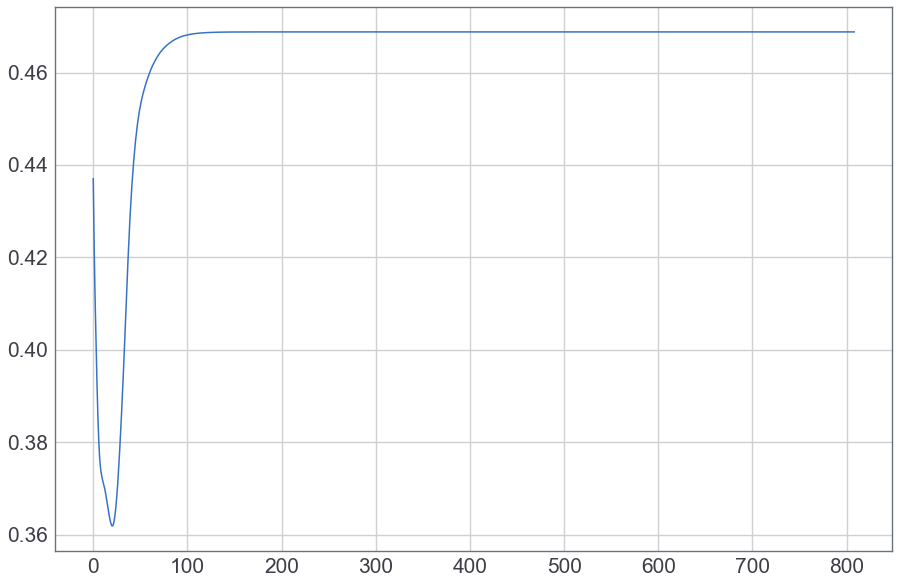

In [67]:
plot(F.sigmoid(stop_probs).data.cpu().numpy())

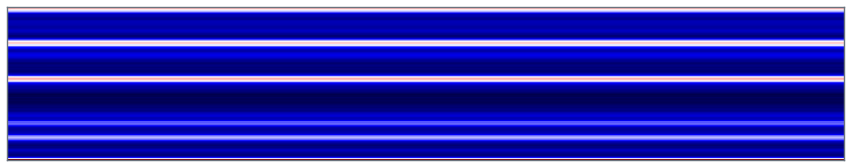

In [68]:
show_images([attn_probs.T], pixel_range='auto', cmap='seismic')

In the many weeks since that time the Congress has devoted itself to the arduous task of formulating legislation necessary to the country's welfare.


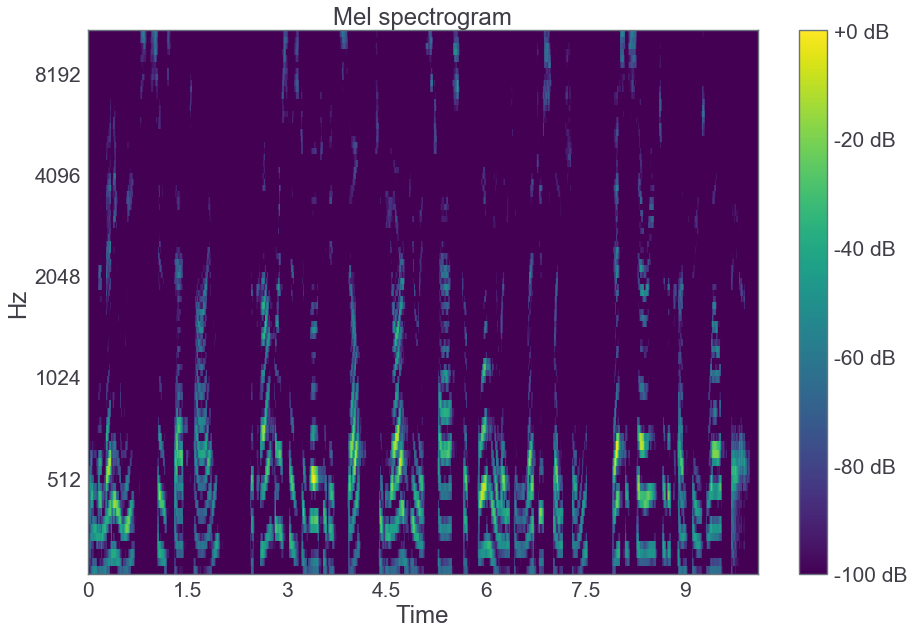

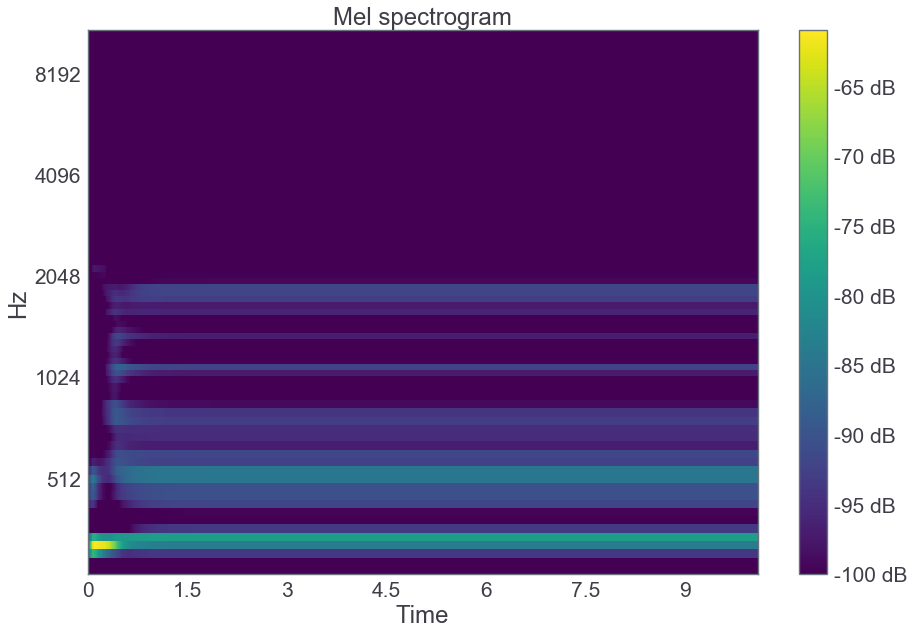

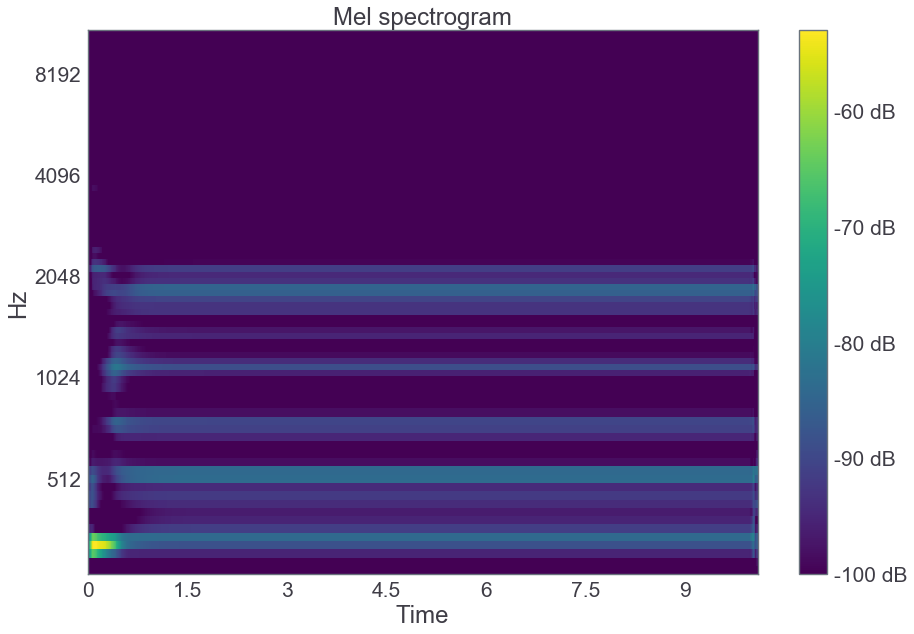

In [69]:
print(read_transcript(sample_transcript.data.cpu().numpy()[0]))
plot_spectrogram(sample_spectrogram.data.cpu().numpy())
plot_spectrogram(pre_preds.data.cpu().numpy())
plot_spectrogram(post_preds.data.cpu().numpy())

# Test

In [ ]:
from scipy.io import wavfile
from utils.vocoder import _griffin_lim

In [ ]:
def vocode(spectrogram):
    return _griffin_lim(spectrogram)

In [ ]:
def test(sentence, stop_threshold=0.9, max_len=500):
    load_model()
    model.eval()
    
    test_transcription = np.array([[char_idx[c] for c in sentence]])
    test_transcription = Variable(cuda(torch.from_numpy(test_transcription)), volatile=True)
    test_spectrogram = model(test_transcription, stop_threshold=stop_threshold, max_len=max_len)[1]
    test_spectrogram = test_spectrogram.data.cpu().numpy()
    
    plot_spectrogram(test_spectrogram)
    
    y = vocode(test_spectrogram)
    plot(y)
    return y

In [ ]:
#y = test('Two young women,')